In [1]:
# pip install gurobipy

In [2]:
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

In [3]:
# global csv filenames
roi1 = 'roi_company1.csv'
roi2 = 'roi_company2.csv'
min_amount = 'min_amount.csv'
roi_monthly = 'roi_monthly.csv'

## PART 3

**For the given ROI data, the ROI is non-increasing with respect to the invested amount, so the
total return is a concave function of the invested amount. To determine the optimal amount
invested in different mediums, this marketing budget allocation problem can be formulated as a
linear program when the return is concave with respect to ROI. You can let the amounts
invested in each tier for each medium be continuous decision variables and then the total
invested amount is the sum of them. The concavity of the return function guarantees that the
invested amount in a tier is positive only when the invested amounts in previous tiers equal
their upper bounds. Use gurobi to find the optimal budget allocation after formulating it as a
linear program.**

In [4]:
roi1 = pd.read_csv(roi1)

# making sure upper bounds are numeric & converting inf to a large number
temp1 = pd.to_numeric(roi1['UpperBound'], errors='coerce')
roi1['UpperBound'] = temp1.fillna(np.inf)

roi1.head()

,Platform,Tier,LowerBound,UpperBound,ROI
0,Print,1,0.0,0.7,0.0345
1,Print,2,0.7,2.7,0.0305
2,Print,3,2.7,4.7,0.0276
3,Print,4,4.7,inf,0.0234
4,TV,1,0.0,4.3,0.0608


In [5]:
# available width for each tier (cannot exceed 3M)
widths1 = []
for idx, row in roi1.iterrows():
    lb = row['LowerBound']
    ub = row['UpperBound']
    effective_ub = min(ub, 3.0)
    widths1.append(max(effective_ub - lb, 0.0))
widths1 = np.array(widths1)

roi1['width1'] = widths1
roi1.head()


,Platform,Tier,LowerBound,UpperBound,ROI,width1
0,Print,1,0.0,0.7,0.0345,0.7
1,Print,2,0.7,2.7,0.0305,2.0
2,Print,3,2.7,4.7,0.0276,0.3
3,Print,4,4.7,inf,0.0234,0.0
4,TV,1,0.0,4.3,0.0608,3.0


In [6]:
# model for the concave case
lp_mod = gp.Model()

# defining one decision variable per tier
x_lp = lp_mod.addMVar(len(roi1), lb=0.0, ub=widths1)

# objective
roi_coeffs = roi1['ROI'].values
lp_mod.setObjective(roi_coeffs @ x_lp, sense=gp.GRB.MAXIMIZE)

Restricted license - for non-production use only - expires 2026-11-23


In [7]:
lp_mod.addConstr(x_lp.sum() == 10.0)

# per platform cap of 3M
for p in roi1['Platform'].unique():
    idx = [i for i,plat in enumerate(roi1['Platform']) if plat == p]
    lp_mod.addConstr(x_lp[idx].sum() <= 3.0)

# Print + TV ≤ Facebook + Email
print_idx = [i for i,p in enumerate(roi1['Platform']) if p in ['Print','TV']]
fb_email_idx = [i for i,p in enumerate(roi1['Platform']) if p in ['Facebook','Email']]
lp_mod.addConstr(x_lp[print_idx].sum() <= x_lp[fb_email_idx].sum())

# social ≥ 2 × (SEO + AdWords)
social_platforms = ['Facebook','LinkedIn','Instagram','Snapchat','Twitter']
search_platforms = ['SEO','AdWords']
social_idx = [i for i,p in enumerate(roi1['Platform']) if p in social_platforms]
search_idx = [i for i,p in enumerate(roi1['Platform']) if p in search_platforms]
lp_mod.addConstr(x_lp[social_idx].sum() >= 2.0 * x_lp[search_idx].sum())

<MConstr () *awaiting model update*>

In [8]:
lp_mod.Params.OutputFlag = 0
lp_mod.optimize()

# summarize optimal spend by platform
allocation_lp = {}
for p in roi1['Platform'].unique():
    idx = [i for i,plat in enumerate(roi1['Platform']) if plat == p]
    allocation_lp[p] = float(x_lp[idx].sum().getValue())

print('Optimal allocation for ROI1 (concave case):')
for p, amt in allocation_lp.items():
    print(f'{p:10s}: {amt:.2f} M')
print(f'Total expected return: {lp_mod.objVal:.4f} million')

Optimal allocation for ROI1 (concave case):
Print     : 0.00 M
TV        : 3.00 M
SEO       : 0.00 M
AdWords   : 1.00 M
Facebook  : 0.00 M
LinkedIn  : 0.00 M
Instagram : 3.00 M
Snapchat  : 0.00 M
Twitter   : 0.00 M
Email     : 3.00 M
Total expected return: 0.5436 million


In [9]:
allocation_lp

{'Print': 0.0,
 'TV': 3.0,
 'SEO': 0.0,
 'AdWords': 1.0,
 'Facebook': 0.0,
 'LinkedIn': 0.0,
 'Instagram': 3.0,
 'Snapchat': 0.0,
 'Twitter': 0.0,
 'Email': 3.0}

## Part 4

**Your boss is happy to see the promising results presented by the marketing department.
However, your boss is also very concerned because your boss recalls being somewhat
disappointed after following such recommendations in the past. To be cautious about the
decision, your team has decided to get another opinion about the ROI data and rerun the
analysis.  The second consulting firm returns the estimates of the ROI data in the CSV file
“roi_company2.csv”. After analyzing the second firm’s ROI data, you find that their ROI’s are not
non-increasing with respect to the invested amount. As a result, the concavity of the total return
is not retained, and it is possible that the tier with a higher ROI will be invested first, while its
previous tiers will be skipped due to their lower ROI’s if you still use the LP model.**

**Inspired by this, to solve the marketing allocation problem when the total return is nonconcave,
you need a binary decision variable for each medium and each tier to determine whether the
invested amount falls in that tier. You also need continuous decision variables to determine the
coefficients for convex combination. You will add constraints like the above ones in the example.
The three constraints above given by your boss are still valid, so think about how you express
them using these decision variables. Formulate the problem as a mixed integer program and
then solve it using gurobi.**

In [10]:
roi2 = pd.read_csv(roi2)
temp2 = pd.to_numeric(roi2['UpperBound'], errors='coerce')
roi2['UpperBound'] = temp2.fillna(np.inf)

In [11]:
# bp / val
platforms = roi2['Platform'].unique()
bp  = {}   # breakpoints of spend (in $M), starting at 0
val = {}   # cumulative return at each breakpoint (in $M)
CAP = 3.0  # per  platform cap

for p in platforms:
    tiers = roi2[roi2['Platform'] == p].sort_values('LowerBound')
    b_list = [0.0]
    v_list = [0.0]
    cur_b  = 0.0
    cur_v  = 0.0
    for _, r in tiers.iterrows():
        lb = float(r['LowerBound'])
        ub = float(min(r['UpperBound'], CAP))
        if ub <= cur_b:
            continue
        seg_lb = max(cur_b, lb)
        seg_ub = ub
        if seg_ub > seg_lb:
            width  = seg_ub - seg_lb
            cur_b  = seg_ub
            cur_v += width * float(r['ROI'])
            b_list.append(cur_b)
            v_list.append(cur_v)
        if cur_b >= CAP:
            break
    bp[p]  = b_list
    val[p] = v_list

In [12]:
# SOS2
m2 = gp.Model('NonConcave_SOS2')

lam = {}     # convex-combination weights per platform
Spend = {}   # platform  spend (0..CAP)
Return = {}  # platform return

for p in platforms:
    K = len(bp[p])
    lam[p] = m2.addVars(K, lb=0.0, name=f"lam[{p}]")
    m2.addConstr(gp.quicksum(lam[p][k] for k in range(K)) == 1, name=f"lam_sum[{p}]")
    m2.addSOS(gp.GRB.SOS_TYPE2, [lam[p][k] for k in range(K)], bp[p])

    Spend[p]  = m2.addVar(lb=0.0, ub=CAP, name=f"Spend[{p}]")
    Return[p] = m2.addVar(lb=0.0, name=f"Return[{p}]")
    m2.addConstr(Spend[p]  == gp.quicksum(bp[p][k]  * lam[p][k] for k in range(K)), name=f"Spend_def[{p}]")
    m2.addConstr(Return[p] == gp.quicksum(val[p][k] * lam[p][k] for k in range(K)), name=f"Return_def[{p}]")

In [13]:
# constraints
BUDGET = 10.0
m2.addConstr(gp.quicksum(Spend[p] for p in platforms) == BUDGET, name="budget")

PT     = ['Print','TV']
FE     = ['Facebook','Email']
SOCIAL = ['Facebook','LinkedIn','Instagram','Snapchat','Twitter']
SEARCH = ['SEO','AdWords']

m2.addConstr(gp.quicksum(Spend[p] for p in PT) <= gp.quicksum(Spend[p] for p in FE), name="pt_le_fe")
m2.addConstr(gp.quicksum(Spend[p] for p in SOCIAL) >= 2.0 * gp.quicksum(Spend[p] for p in SEARCH), name="social_ge_2x_search")


<gurobi.Constr *Awaiting Model Update*>

In [14]:
# Objective, solve, report
m2.Params.OutputFlag = 0
m2.setObjective(gp.quicksum(Return[p] for p in platforms), gp.GRB.MAXIMIZE)
m2.optimize()

alloc_mip = {p: Spend[p].X for p in platforms}
obj_mip   = sum(Return[p].X for p in platforms)

print(pd.Series(alloc_mip, name='Spend (in $MM)').sort_values(ascending=False))
print(f"Total expected return: {obj_mip:.4f}")


Print        3.000000
Facebook     3.000000
AdWords      2.333333
LinkedIn     1.666667
TV           0.000000
SEO          0.000000
Instagram    0.000000
Snapchat     0.000000
Twitter      0.000000
Email        0.000000
Name: Spend (in $MM), dtype: float64
Total expected return: 0.4528


In [15]:
alloc_mip

{'Print': 3.0,
 'TV': 0.0,
 'SEO': 0.0,
 'AdWords': 2.3333333333333335,
 'Facebook': 3.0,
 'LinkedIn': 1.6666666666666667,
 'Instagram': 0.0,
 'Snapchat': 0.0,
 'Twitter': 0.0,
 'Email': 0.0}

## PART 5

**Are the allocations the same?  Assuming the first ROI data is correct, if you were to use the
second allocation (the allocation that assumed the second ROI data was correct) how much
lower would the objective be relative to the optimal objective (the one that uses the first ROI
data and the first allocation)?  Assuming the second ROI data is correct, if you used the first
allocation how much lower would the objective be relative to the optimal objective?  Do you
think the third constraint above, based on your boss’ experience, is useful?**

In [16]:
#Allocation results from previous parts
alloc_lp = allocation_lp
obj_lp = lp_mod.objVal # million return from LP (ROI1 optimal)

obj_mip = m2.objVal # million return from MIP (ROI2 optimal)

#Function to compute expected return given ROI data + allocation
def compute_return(roi_df, allocation):
    total_return = 0.0
    for platform, invest in allocation.items():
        if invest <= 0:
            continue
        # dfp = roi_df[roi_df['Platform'] == platform].copy()
        dfp = roi_df[roi_df['Platform'] == platform].copy().sort_values(by='LowerBound')
        remaining = invest
        for _, row in dfp.iterrows():
            lb, ub, roi = row['LowerBound'], row['UpperBound'], row['ROI']
            tier_cap = ub - lb if np.isfinite(ub) else remaining
            amount = min(remaining, tier_cap)
            if amount > 0:
                total_return += amount * roi
                remaining -= amount
            if remaining <= 1e-6:
                break
    return total_return

#Cross-evaluate
ret_lp_on_roi2 = compute_return(roi2, alloc_lp)
ret_mip_on_roi1 = compute_return(roi1, alloc_mip)

#Compute losses
loss_lp_under_roi2 = obj_mip - ret_lp_on_roi2
rel_loss_lp_under_roi2 = 100 * loss_lp_under_roi2 / obj_mip

loss_mip_under_roi1 = obj_lp - ret_mip_on_roi1
rel_loss_mip_under_roi1 = 100 * loss_mip_under_roi1 / obj_lp

In [17]:
#Print results
print("Cross-evaluation results")
print(f"Optimal ROI1 objective: {obj_lp:.6f}")
print(f"Optimal ROI2 objective: {obj_mip:.6f}\n")

print(f"ROI1 optimal allocation used on ROI2 data: {ret_lp_on_roi2:.6f}")
print(f"Loss: {loss_lp_under_roi2:.6f} ({rel_loss_lp_under_roi2:.2f}% lower)\n")

print(f"ROI2 optimal allocation used on ROI1 data: {ret_mip_on_roi1:.6f}")
print(f"Loss: {loss_mip_under_roi1:.6f} ({rel_loss_mip_under_roi1:.2f}% lower)\n")

Cross-evaluation results
Optimal ROI1 objective: 0.543640
Optimal ROI2 objective: 0.452827

ROI1 optimal allocation used on ROI2 data: 0.277720
Loss: 0.175107 (38.67% lower)

ROI2 optimal allocation used on ROI1 data: 0.274903
Loss: 0.268737 (49.43% lower)



No, the allocations are not the same.
- Part-3 optimal (ROI 1) objective = 0.543640.
- Part-4 optimal (ROI 2) objective = 0.45280

If ROI 1 is actually correct and we instead use the Part-4 allocation:
- Return drops from 0.543640 → 0.274881
- Absolute loss = 0.268737 million.
- Relative loss = 49.43% of the ROI 1 optimum.


If ROI 2 is actually correct and we instead use the Part-3 allocation:
- Return drops from 0.452800 → 0.277720
- Absolute loss = 0.17508 million.
- Relative loss = 38.67% of the ROI 2 optimum.


Interpretation:
The two allocations are  different and each performs substantially worse when evaluated under the other firm’s ROI estimates.
The per-platform cap (the 3M max — our third constraint) is a useful risk-control measure: it prevents extreme concentration in a single channel and limits exposure to estimation error. In these runs several platforms hit the 3M cap, so that constraint is binding and meaningfully shapes the solution.


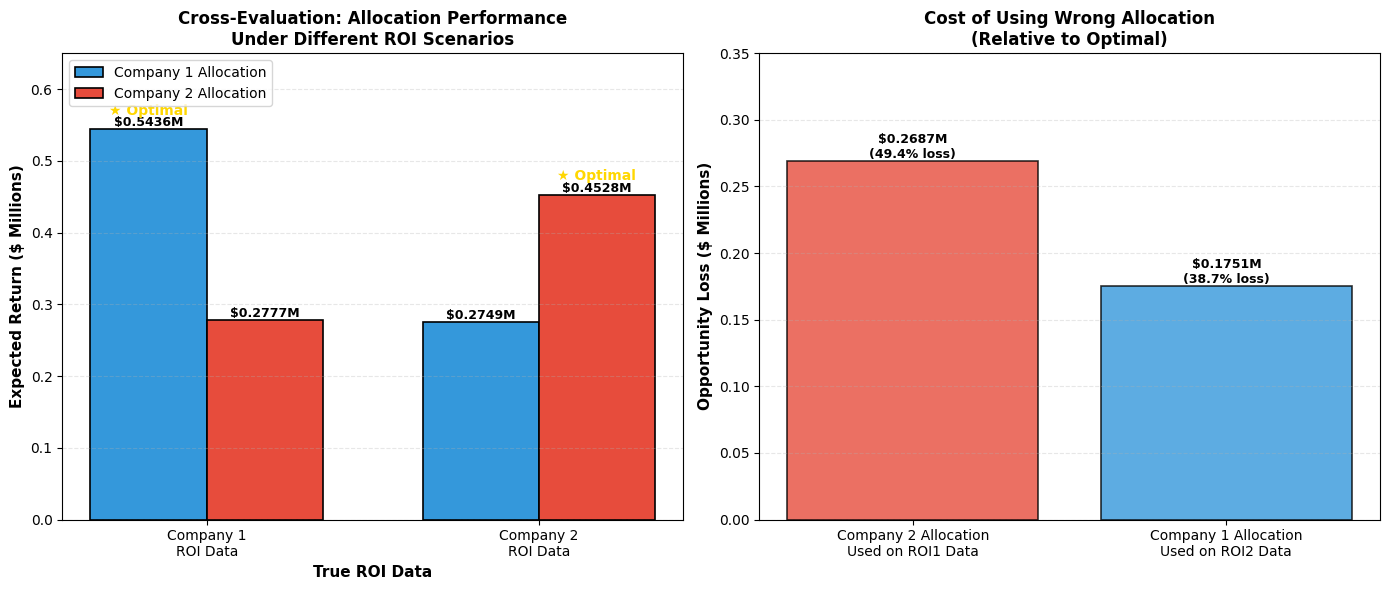

In [18]:
# Data setup
scenarios = ['Company 1\nROI Data', 'Company 2\nROI Data']
company1_alloc = [obj_lp, ret_mip_on_roi1]  # Optimal under ROI1, Applied to ROI1 & ROI2
company2_alloc = [ret_lp_on_roi2, obj_mip]  # Optimal under ROI2, Applied to ROI1 & ROI2

x = np.arange(len(scenarios))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Cross-evaluation returns
bars1 = ax1.bar(x - width/2, company1_alloc, width, label='Company 1 Allocation',
                color='#3498db', edgecolor='black', linewidth=1.2)
bars2 = ax1.bar(x + width/2, company2_alloc, width, label='Company 2 Allocation',
                color='#e74c3c', edgecolor='black', linewidth=1.2)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'${height:.4f}M',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# Highlight optimal scenarios with stars
ax1.text(0 - width/2, company1_alloc[0] + 0.02, '★ Optimal',
         ha='center', fontsize=10, color='gold', fontweight='bold')
ax1.text(1 + width/2, company2_alloc[1] + 0.02, '★ Optimal',
         ha='center', fontsize=10, color='gold', fontweight='bold')

ax1.set_ylabel('Expected Return ($ Millions)', fontsize=11, fontweight='bold')
ax1.set_xlabel('True ROI Data', fontsize=11, fontweight='bold')
ax1.set_title('Cross-Evaluation: Allocation Performance\nUnder Different ROI Scenarios',
              fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(scenarios)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_ylim(0, 0.65)

# Right plot: Loss analysis
losses = [loss_mip_under_roi1, loss_lp_under_roi2]
loss_pcts = [rel_loss_mip_under_roi1, rel_loss_lp_under_roi2]
scenarios_loss = ['Company 2 Allocation\nUsed on ROI1 Data',
                  'Company 1 Allocation\nUsed on ROI2 Data']

bars3 = ax2.bar(scenarios_loss, losses, color=['#e74c3c', '#3498db'],
                edgecolor='black', linewidth=1.2, alpha=0.8)

# Add dual labels (absolute + percentage)
for i, (bar, pct) in enumerate(zip(bars3, loss_pcts)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:.4f}M\n({pct:.1f}% loss)',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

ax2.set_ylabel('Opportunity Loss ($ Millions)', fontsize=11, fontweight='bold')
ax2.set_title('Cost of Using Wrong Allocation\n(Relative to Optimal)',
              fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_ylim(0, 0.35)

plt.tight_layout()
plt.savefig('cross_evaluation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


## PART 6

**After conducting preliminary marketing research, your company find that there is a minimum
amount for each medium such that any investment below this amount would be insufficient to
generate meaningful impact. In this case, for each medium, you will either not invest or invest at
least that minimum amount. These minimum amounts are given in the attached csv file
“min_amount.csv”. Embed this rule in the mixed integer program model and solve the problem
again with the second firm’s ROI data. What is the optimal allocation?**

Each platform now has a binary variable zp:
- zp = 1: You invest in that platform
- zp = 0: You invest nothing
- If zp = 1, total investment in that platform >= given minimum (from the CSV)

All previous contraints (budget, platform cap, social/print rules etc.) are kept

In [19]:
# 1. Load minimum investment data
min_df = pd.read_csv(min_amount)
min_map = dict(zip(min_df['Platform'], min_df['MinInvestment']))

# 2. Setup model and variables
m6 = gp.Model('MinInvest_SOS2')
m6.Params.OutputFlag = 0

lam = {}     # Lambda weights
Spend = {}   # Spend per platform
Return = {}  # Return per platform
z_p = m6.addVars(platforms, vtype=GRB.BINARY, name="z_p") # Platform On/Off

# 3. Define variables and constraints
for p in platforms:
    K = len(bp[p]) # Number of breakpoints for platform p
    lam[p] = m6.addVars(K, lb=0.0, name=f"lam[{p}]")

    # Link z_p to lambdas: sum(lam) == z_p
    # If z_p=0 (off), all lam=0 -> Spend=0.
    # If z_p=1 (on), sum(lam)=1 (convex combination).
    m6.addConstr(gp.quicksum(lam[p][k] for k in range(K)) == z_p[p], name=f"lam_sum[{p}]")

    # SOS2 constraint (only 2 adjacent lambdas can be non-zero)
    m6.addSOS(GRB.SOS_TYPE2, [lam[p][k] for k in range(K)], bp[p])

    # Define Spend/Return from lambdas (same as Part 4)
    Spend[p] = m6.addVar(lb=0.0, ub=CAP, name=f"Spend[{p}]")
    Return[p] = m6.addVar(lb=0.0, name=f"Return[{p}]")
    m6.addConstr(Spend[p] == gp.quicksum(bp[p][k] * lam[p][k] for k in range(K)), name=f"Spend_def[{p}]")
    m6.addConstr(Return[p] == gp.quicksum(val[p][k] * lam[p][k] for k in range(K)), name=f"Return_def[{p}]")

    # Spend must be >= min_amount if z_p=1
    m6.addConstr(Spend[p] >= min_map[p] * z_p[p], name=f"min_invest[{p}]")

# 4. Budget & Boss Constraints (using 'Spend' dict)
BUDGET = 10.0
PT = ['Print','TV']
FE = ['Facebook','Email']
SOCIAL = ['Facebook','LinkedIn','Instagram','Snapchat','Twitter']
SEARCH = ['SEO','AdWords']

m6.addConstr(gp.quicksum(Spend[p] for p in platforms) <= BUDGET, name="budget")
m6.addConstr(gp.quicksum(Spend[p] for p in PT) <= gp.quicksum(Spend[p] for p in FE), name="pt_le_fe")
m6.addConstr(gp.quicksum(Spend[p] for p in SOCIAL) >= 2.0 * gp.quicksum(Spend[p] for p in SEARCH), name="social_ge_2x_search")

# 5. Objective, solve, and report
m6.setObjective(gp.quicksum(Return[p] for p in platforms), GRB.MAXIMIZE)
m6.optimize()

# Save results for your visualization cell
allocation_min = {p: Spend[p].X for p in platforms}
obj_min = m6.objVal
mip_min = m6 # For your viz cell

print("=== Optimal allocation with minimum investment rule (SOS2) ===")
for p, amt in sorted(allocation_min.items(), key=lambda item: item[1], reverse=True):
    if amt > 1e-6:
        print(f"{p:10s}: {amt:.2f}M")
    else:
        print(f"{p:10s}: 0.00M")
print(f"Total expected return: {obj_min:.4f} million")

=== Optimal allocation with minimum investment rule (SOS2) ===
Print     : 3.00M
Facebook  : 3.00M
AdWords   : 2.33M
LinkedIn  : 1.67M
TV        : 0.00M
SEO       : 0.00M
Instagram : 0.00M
Snapchat  : 0.00M
Twitter   : 0.00M
Email     : 0.00M
Total expected return: 0.4528 million


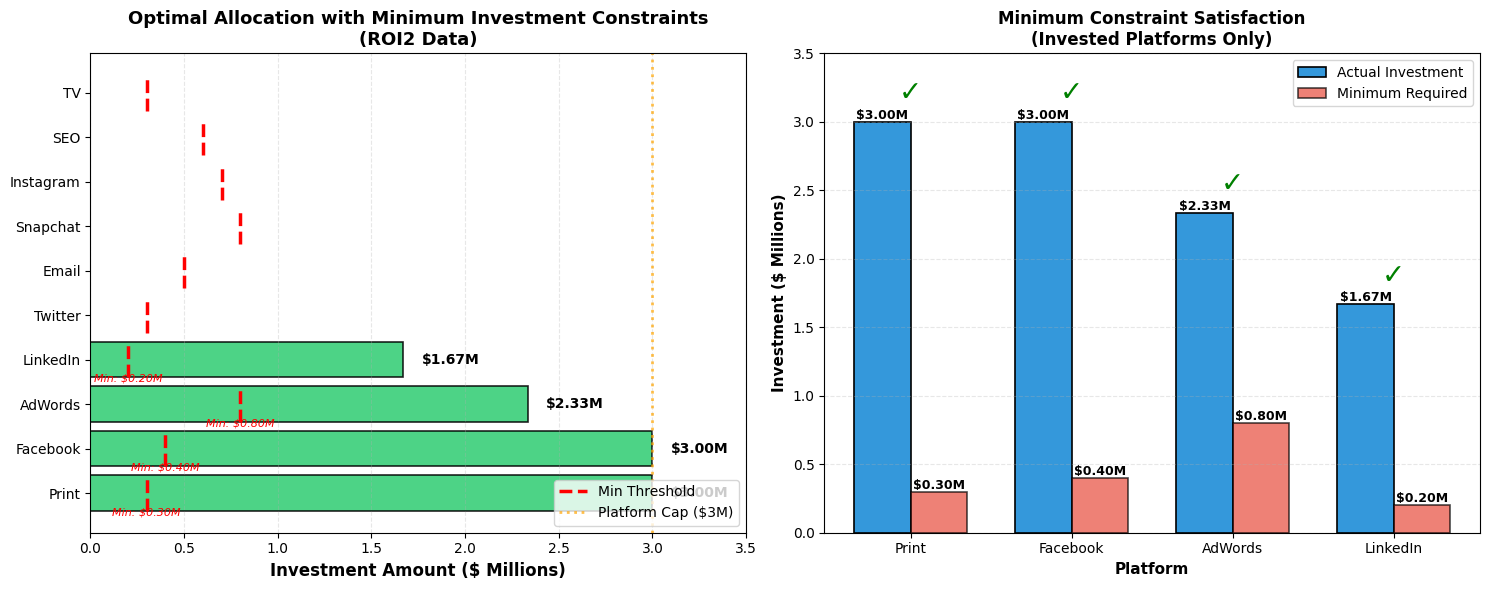


ALLOCATION SUMMARY: Minimum Investment Constraint Analysis
Platform       Investment      Minimum          Status
----------------------------------------------------------------------
Print        $      3.00M  $      0.30M      ✓ Satisfied
Facebook     $      3.00M  $      0.40M      ✓ Satisfied
AdWords      $      2.33M  $      0.80M      ✓ Satisfied
LinkedIn     $      1.67M  $      0.20M      ✓ Satisfied
Twitter      $      0.00M  $      0.30M     Not Invested
Email        $      0.00M  $      0.50M     Not Invested
Snapchat     $      0.00M  $      0.80M     Not Invested
Instagram    $      0.00M  $      0.70M     Not Invested
SEO          $      0.00M  $      0.60M     Not Invested
TV           $      0.00M  $      0.30M     Not Invested
Total Budget Used:        $10.00M
Total Expected Return:    $0.452827M ($452,827)
Average ROI:              4.53%
Platforms Invested:       4/10


In [20]:
#Visualization
# Data preparation
platforms = list(allocation_min.keys())
investments = [allocation_min[p] for p in platforms]
minimums = [min_map.get(p, 0) for p in platforms]

# Sort by investment amount for better visualization
sorted_indices = np.argsort(investments)[::-1]
platforms_sorted = [platforms[i] for i in sorted_indices]
investments_sorted = [investments[i] for i in sorted_indices]
minimums_sorted = [minimums[i] for i in sorted_indices]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left plot: Investment amounts with minimum thresholds
colors = ['#2ecc71' if inv > 0 else '#95a5a6' for inv in investments_sorted]
bars = ax1.barh(platforms_sorted, investments_sorted, color=colors,
                edgecolor='black', linewidth=1.2, alpha=0.85)

# Add minimum threshold markers
for i, (plat, inv, min_amt) in enumerate(zip(platforms_sorted, investments_sorted, minimums_sorted)):
    if min_amt > 0:
        ax1.plot([min_amt, min_amt], [i-0.4, i+0.4], 'r--', linewidth=2.5, label='Min Threshold' if i == 0 else '')
        if inv > 0:  # Only annotate invested platforms
            ax1.text(min_amt, i-0.5, f'Min: ${min_amt:.2f}M',
                    fontsize=8, color='red', ha='center', style='italic')

# Add investment value labels
for i, (bar, inv) in enumerate(zip(bars, investments_sorted)):
    if inv > 0:
        ax1.text(inv + 0.1, bar.get_y() + bar.get_height()/2,
                f'${inv:.2f}M', va='center', fontsize=10, fontweight='bold')

ax1.axvline(x=3.0, color='orange', linestyle=':', linewidth=2, alpha=0.7, label='Platform Cap ($3M)')
ax1.set_xlabel('Investment Amount ($ Millions)', fontsize=12, fontweight='bold')
ax1.set_title('Optimal Allocation with Minimum Investment Constraints\n(ROI2 Data)',
              fontsize=13, fontweight='bold')
ax1.set_xlim(0, 3.5)
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(axis='x', alpha=0.3, linestyle='--')

# Right plot: Constraint satisfaction check
invested_platforms = [p for p, inv in zip(platforms_sorted, investments_sorted) if inv > 0]
invested_amounts = [inv for inv in investments_sorted if inv > 0]
invested_minimums = [minimums_sorted[i] for i, inv in enumerate(investments_sorted) if inv > 0]

x_pos = np.arange(len(invested_platforms))
width = 0.35

bars1 = ax2.bar(x_pos - width/2, invested_amounts, width, label='Actual Investment',
               color='#3498db', edgecolor='black', linewidth=1.2)
bars2 = ax2.bar(x_pos + width/2, invested_minimums, width, label='Minimum Required',
               color='#e74c3c', edgecolor='black', linewidth=1.2, alpha=0.7)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'${height:.2f}M', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Add checkmarks for satisfied constraints
for i, (inv, min_amt) in enumerate(zip(invested_amounts, invested_minimums)):
    if inv >= min_amt:
        ax2.text(i, max(inv, min_amt) + 0.15, '✓', fontsize=20,
                color='green', ha='center', fontweight='bold')

ax2.set_ylabel('Investment ($ Millions)', fontsize=11, fontweight='bold')
ax2.set_xlabel('Platform', fontsize=11, fontweight='bold')
ax2.set_title('Minimum Constraint Satisfaction\n(Invested Platforms Only)',
              fontsize=12, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(invested_platforms, rotation=0, ha='center')
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_ylim(0, 3.5)

plt.tight_layout()
plt.savefig('minimum_investment_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary table
print("\n" + "="*70)
print("ALLOCATION SUMMARY: Minimum Investment Constraint Analysis")
print("="*70)
print(f"{'Platform':<12} {'Investment':>12} {'Minimum':>12} {'Status':>15}")
print("-"*70)
for p, inv, min_amt in zip(platforms_sorted, investments_sorted, minimums_sorted):
    if inv > 0:
        status = "✓ Satisfied" if inv >= min_amt else "✗ Violated"
        print(f"{p:<12} ${inv:>10.2f}M  ${min_amt:>10.2f}M  {status:>15}")
    else:
        print(f"{p:<12} ${inv:>10.2f}M  ${min_amt:>10.2f}M  {'Not Invested':>15}")
print("="*70)
print(f"{'Total Budget Used:':<25} ${sum(investments_sorted):.2f}M")
print(f"{'Total Expected Return:':<25} ${mip_min.objVal:.6f}M (${mip_min.objVal*1e6:,.0f})")
print(f"{'Average ROI:':<25} {(mip_min.objVal/sum(investments_sorted)*100):.2f}%")
print(f"{'Platforms Invested:':<25} {sum(1 for inv in investments_sorted if inv > 0)}/10")
print("="*70)

## PART 7

**Your boss has gained permission to reinvest half of the return. For example, if the marketing
obtains a 4% return in January, the budget of February will be $10M + $10M × 4% × 50% =
$10.2M.  The monthly ROI for next year is given in the file “roi_monthly.csv”. The three
constraints given by your boss and the constraint for the minimum amounts are still in place for
each month. You need to implement the minimum amount constraint in Part 6). What is
the optimal allocation for each month?**

In [21]:
# 1. Load monthly data
roi_monthly = pd.read_csv(roi_monthly)
roi_monthly["UpperBoundM"] = pd.to_numeric(roi_monthly["UpperBoundM"], errors="coerce").fillna(np.inf)

# 2. Define the SOS2 model-builder function
def build_monthly_mip_sos2(df, budget, min_map):
    """
    Builds a monthly MIP using the SOS2 formulation.
    This function calculates breakpoints internally for the given month's 'df'.
    """
    m = gp.Model()
    m.Params.LogToConsole = 0
    platforms = df["Platform"].unique()
    CAP = 3.0

    # --- 1. Calculate Breakpoints & Values for *this* month ---
    bp = {}
    val = {}
    for p in platforms:
        tiers = df[df['Platform'] == p].sort_values('LowerBoundM')
        b_list = [0.0]
        v_list = [0.0]
        cur_b = 0.0
        cur_v = 0.0
        for _, r in tiers.iterrows():
            lb = float(r['LowerBoundM'])
            ub = float(min(r['UpperBoundM'], CAP))
            if ub <= cur_b:
                continue
            seg_lb = max(cur_b, lb)
            seg_ub = ub
            if seg_ub > seg_lb:
                width = seg_ub - seg_lb
                cur_b = seg_ub
                cur_v += width * float(r['ROI'])
                b_list.append(cur_b)
                v_list.append(cur_v)
            if cur_b >= CAP:
                break
        bp[p] = b_list
        val[p] = v_list

    # --- 2. Define Variables (z_p, lam, Spend, Return) ---
    lam = {}
    Spend = {}
    Return = {}
    z_p = m.addVars(platforms, vtype=GRB.BINARY, name="z_p")

    for p in platforms:
        K = len(bp[p])
        lam[p] = m.addVars(K, lb=0.0, name=f"lam[{p}]")
        m.addConstr(gp.quicksum(lam[p][k] for k in range(K)) == z_p[p], name=f"lam_sum[{p}]")
        m.addSOS(GRB.SOS_TYPE2, [lam[p][k] for k in range(K)], bp[p])

        Spend[p] = m.addVar(lb=0.0, ub=CAP, name=f"Spend[{p}]")
        Return[p] = m.addVar(lb=0.0, name=f"Return[{p}]")
        m.addConstr(Spend[p] == gp.quicksum(bp[p][k] * lam[p][k] for k in range(K)), name=f"Spend_def[{p}]")
        m.addConstr(Return[p] == gp.quicksum(val[p][k] * lam[p][k] for k in range(K)), name=f"Return_def[{p}]")

        # Minimum Investment
        m.addConstr(Spend[p] >= min_map[p] * z_p[p], name=f"min_invest[{p}]")

    # --- 3. Constraints ---
    m.addConstr(gp.quicksum(Spend[p] for p in platforms) <= budget, name="budget")

    PT = ['Print','TV']
    FE = ['Facebook','Email']
    SOCIAL = ['Facebook','LinkedIn','Instagram','Snapchat','Twitter']
    SEARCH = ['SEO','AdWords']

    m.addConstr(gp.quicksum(Spend[p] for p in PT if p in platforms) <=
                gp.quicksum(Spend[p] for p in FE if p in platforms), name="pt_le_fe")

    m.addConstr(gp.quicksum(Spend[p] for p in SOCIAL if p in platforms) >=
                2.0 * gp.quicksum(Spend[p] for p in SEARCH if p in platforms), name="social_ge_2x_search")

    # --- 4. Objective ---
    m.setObjective(gp.quicksum(Return[p] for p in platforms), GRB.MAXIMIZE)

    return m, Spend  # Return model and Spend vars

# --- 3. Run the monthly loop ---
months = list(roi_monthly["Month"].unique())
budgets = {"Jan": 10.0}
results = []

for i, month in enumerate(months):
    dfm = roi_monthly[roi_monthly["Month"] == month].reset_index(drop=True)
    budget = budgets[month]

    # Call the SOS2 MIP builder
    m, Spend = build_monthly_mip_sos2(dfm, budget, min_map)
    m.optimize()

    # Extract results directly from the 'Spend' dictionary
    alloc_by_platform = {p: Spend[p].X for p in dfm["Platform"].unique()}

    total_return_amount = m.objVal
    avg_roi = total_return_amount / budget

    row = {"Month": month, "Budget": budget, "ROI(%)": avg_roi * 100,
           "Return($M)": total_return_amount}
    row.update(alloc_by_platform)
    results.append(row)

    # Update next month's budget
    if i + 1 < len(months):
        budgets[months[i + 1]] = budget + 0.5 * total_return_amount

# --- 4. Display Results ---
results_df = pd.DataFrame(results).fillna(0)
results_df = results_df.round(4)
pd.set_option("display.max_columns", None)
display(results_df)

Set parameter LogToConsole to value 0
Set parameter LogToConsole to value 0
Set parameter LogToConsole to value 0
Set parameter LogToConsole to value 0
Set parameter LogToConsole to value 0
Set parameter LogToConsole to value 0
Set parameter LogToConsole to value 0
Set parameter LogToConsole to value 0
Set parameter LogToConsole to value 0
Set parameter LogToConsole to value 0
Set parameter LogToConsole to value 0
Set parameter LogToConsole to value 0


,Month,Budget,ROI(%),Return($M),Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email
0,Jan,10.0000,5.3942,0.5394,3.0000,0.0,0.0,0.0000,3.0000,3.0,0.0000,0.000,1.0000,0.0000
1,Feb,10.2697,4.0967,0.4207,2.3000,0.0,0.0,2.6566,2.4131,2.1,0.0000,0.800,0.0000,0.0000
2,Mar,10.4801,5.2363,0.5488,2.3920,0.0,0.0,2.6960,2.3920,3.0,0.0000,0.000,0.0000,0.0000
3,Apr,10.7545,4.8696,0.5237,3.0000,0.0,0.0,1.7545,3.0000,3.0,0.0000,0.000,0.0000,0.0000
4,May,11.0163,5.7328,0.6315,3.0000,0.0,0.0,0.0000,0.0000,3.0,2.0163,0.000,0.0000,3.0000
5,Jun,11.3321,4.6811,0.5305,3.0000,0.0,0.0,0.0000,3.0000,3.0,0.0000,0.000,2.3321,0.0000
6,Jul,11.5973,5.2717,0.6114,2.5973,0.0,3.0,0.0000,3.0000,3.0,0.0000,0.000,0.0000,0.0000
7,Aug,11.9030,5.1813,0.6167,0.6000,0.0,0.0,3.0000,0.6000,3.0,0.0000,1.703,3.0000,0.0000
8,Sep,12.2114,5.3383,0.6519,3.0000,0.0,0.0,2.3705,0.9000,3.0,0.8409,0.000,0.0000,2.1000
9,Oct,12.5373,5.9686,0.7483,3.0000,0.0,0.0,0.0000,3.0000,3.0,0.0000,0.000,3.0000,0.5373


In [22]:
total_annual_return = results_df['Return($M)'].sum()
print(f"Total annual return across all months: ${total_annual_return:.4f} million")

# Calculate and print the average monthly ROI
average_monthly_roi = results_df['ROI(%)'].mean()
print(f"Average monthly ROI: {average_monthly_roi:.2f}%")

Total annual return across all months: $7.0834 million
Average monthly ROI: 5.12%



ANNUAL SUMMARY: Dynamic Budget Allocation with Reinvestment
Metric                                                  Value
--------------------------------------------------------------------------------
Initial Budget (January):                $           10.0000M
Final Budget (December):                 $           13.2334M
Budget Growth:                                       32.33%
Total Invested (Sum of monthly budgets): $          138.2465M
Total Return (Sum of monthly returns):   $            7.0834M
Aggregate ROI:                                       70.83%
Average Monthly ROI:                                  5.12%
Best Month (ROI):                                         Oct
Worst Month (ROI):                                        Feb

PLATFORM INVESTMENT FREQUENCY:
--------------------------------------------------------------------------------
Print           Invested: 12/12 months  |  Avg when invested: $  2.66M
TV              Invested:  0/12 months  |  Avg when invested

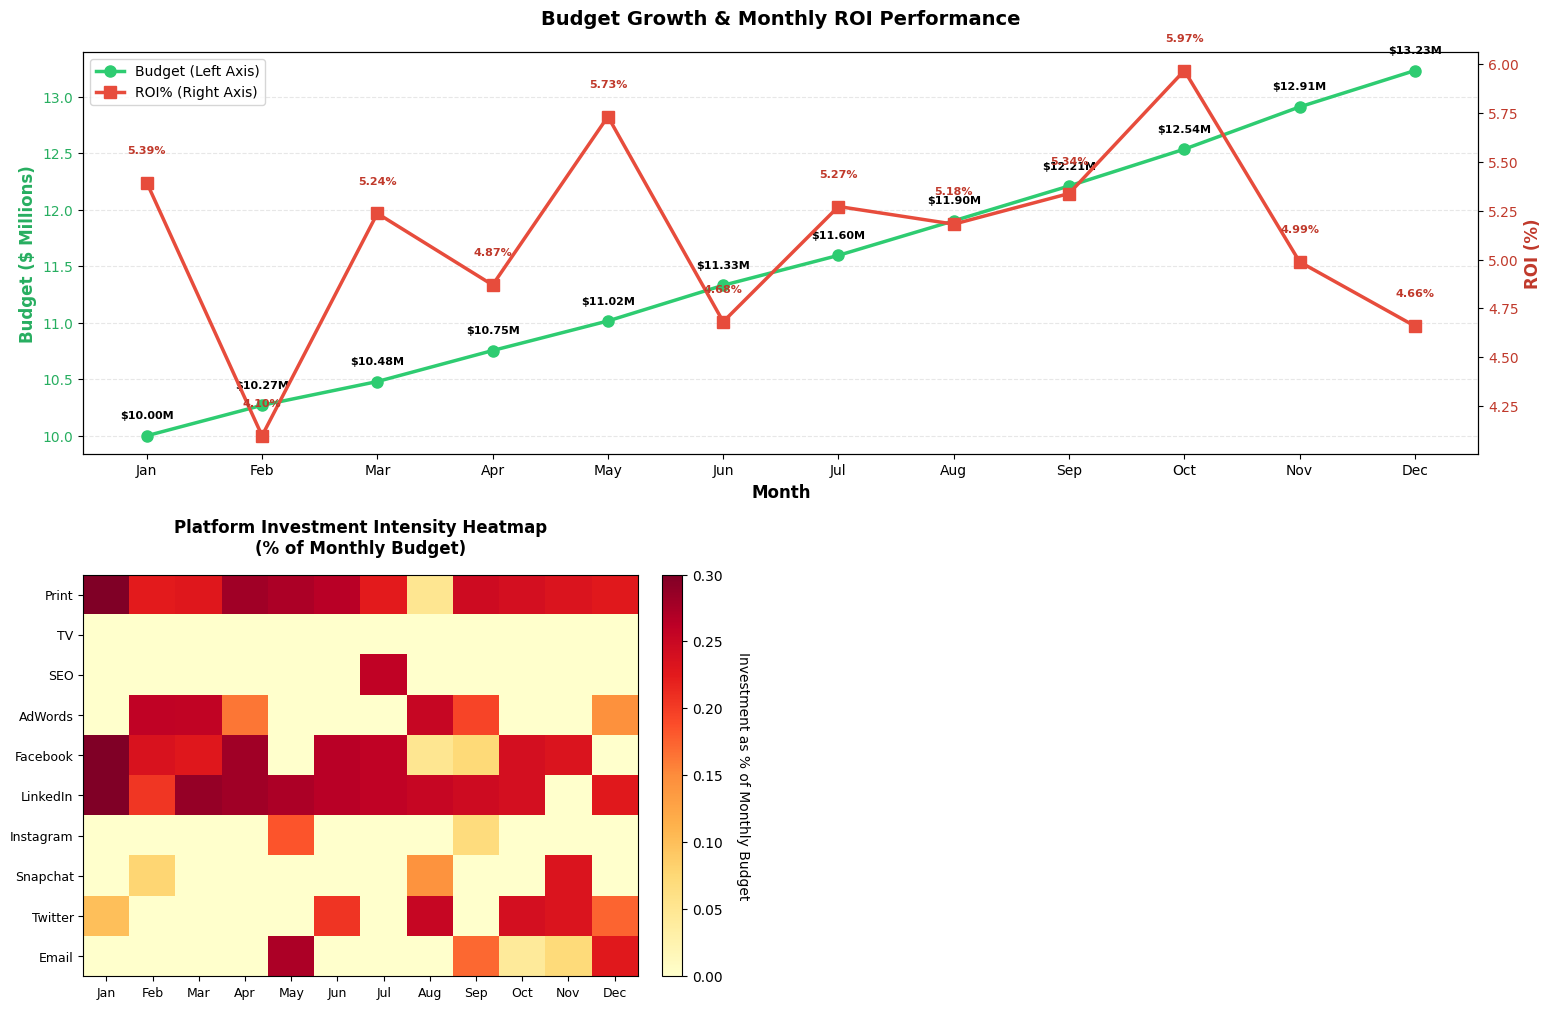

In [23]:
# Prepare data
results_df_viz = results_df.copy()
months_ordered = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
results_df_viz['Month'] = pd.Categorical(results_df_viz['Month'],
                                          categories=months_ordered, ordered=True)
results_df_viz = results_df_viz.sort_values('Month')

# Platform columns
platform_cols = ['Print', 'TV', 'SEO', 'AdWords', 'Facebook',
                 'LinkedIn', 'Instagram', 'Snapchat', 'Twitter', 'Email']

# Create figure with 3 subplots
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# ========== Plot 1: Budget Growth & ROI Over Time ==========
ax1 = fig.add_subplot(gs[0, :])
ax1_twin = ax1.twinx()

# Budget line
line1 = ax1.plot(results_df_viz['Month'], results_df_viz['Budget'],
                 marker='o', linewidth=2.5, markersize=8, color='#2ecc71',
                 label='Budget (Left Axis)', zorder=3)
# ROI line
line2 = ax1_twin.plot(results_df_viz['Month'], results_df_viz['ROI(%)'],
                      marker='s', linewidth=2.5, markersize=8, color='#e74c3c',
                      label='ROI% (Right Axis)', zorder=3)

# Add value labels
for i, (month, budget, roi) in enumerate(zip(results_df_viz['Month'],
                                              results_df_viz['Budget'],
                                              results_df_viz['ROI(%)'])):
    ax1.text(i, budget + 0.15, f'${budget:.2f}M', ha='center', fontsize=8, fontweight='bold')
    ax1_twin.text(i, roi + 0.15, f'{roi:.2f}%', ha='center', fontsize=8,
                  fontweight='bold', color='#c0392b')

ax1.set_xlabel('Month', fontsize=12, fontweight='bold')
ax1.set_ylabel('Budget ($ Millions)', fontsize=12, fontweight='bold', color='#27ae60')
ax1_twin.set_ylabel('ROI (%)', fontsize=12, fontweight='bold', color='#c0392b')
ax1.set_title('Budget Growth & Monthly ROI Performance', fontsize=14, fontweight='bold', pad=20)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.tick_params(axis='y', labelcolor='#27ae60')
ax1_twin.tick_params(axis='y', labelcolor='#c0392b')

# Combined legend
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=10)

# ========== Plot 2: Heatmap - Platform Investment Intensity ==========
ax3 = fig.add_subplot(gs[1, 0])

# Create heatmap data (normalize by month's budget for comparison)
heatmap_data = results_df_viz[platform_cols].div(results_df_viz['Budget'], axis=0).values.T

im = ax3.imshow(heatmap_data, cmap='YlOrRd', aspect='auto', interpolation='nearest')

# Set ticks
ax3.set_xticks(np.arange(len(months_ordered)))
ax3.set_yticks(np.arange(len(platform_cols)))
ax3.set_xticklabels(months_ordered, fontsize=9)
ax3.set_yticklabels(platform_cols, fontsize=9)

# Add colorbar
cbar = plt.colorbar(im, ax=ax3, fraction=0.046, pad=0.04)
cbar.set_label('Investment as % of Monthly Budget', rotation=270, labelpad=20, fontsize=10)

ax3.set_title('Platform Investment Intensity Heatmap\n(% of Monthly Budget)',
              fontsize=12, fontweight='bold', pad=15)


# ========== Summary Statistics Table ==========
print("\n" + "="*80)
print("ANNUAL SUMMARY: Dynamic Budget Allocation with Reinvestment")
print("="*80)
print(f"{'Metric':<40} {'Value':>20}")
print("-"*80)
print(f"{'Initial Budget (January):':<40} ${results_df_viz.iloc[0]['Budget']:>18.4f}M")
print(f"{'Final Budget (December):':<40} ${results_df_viz.iloc[-1]['Budget']:>18.4f}M")
print(f"{'Budget Growth:':<40} {((results_df_viz.iloc[-1]['Budget']/results_df_viz.iloc[0]['Budget'])-1)*100:>17.2f}%")
print(f"{'Total Invested (Sum of monthly budgets):':<40} ${results_df_viz['Budget'].sum():>18.4f}M")
print(f"{'Total Return (Sum of monthly returns):':<40} ${results_df_viz['Return($M)'].sum():>18.4f}M")
print(f"{'Aggregate ROI:':<40} {(results_df_viz['Return($M)'].sum()/results_df_viz.iloc[0]['Budget'])*100:>17.2f}%")
print(f"{'Average Monthly ROI:':<40} {results_df_viz['ROI(%)'].mean():>17.2f}%")
print(f"{'Best Month (ROI):':<40} {results_df_viz.loc[results_df_viz['ROI(%)'].idxmax(), 'Month']:>20}")
print(f"{'Worst Month (ROI):':<40} {results_df_viz.loc[results_df_viz['ROI(%)'].idxmin(), 'Month']:>20}")
print("="*80)

# Platform investment frequency
print("\nPLATFORM INVESTMENT FREQUENCY:")
print("-"*80)
for col in platform_cols:
    months_invested = (results_df_viz[col] > 0.01).sum()
    avg_when_invested = results_df_viz[results_df_viz[col] > 0.01][col].mean()
    print(f"{col:<15} Invested: {months_invested:>2}/12 months  |  "
          f"Avg when invested: ${avg_when_invested:>6.2f}M")
print("="*80)

## PART 8

**A stable budget is defined as a monthly allocation such that for each platform the monthly
change in spend is no more than $1M. Is the allocation you found stable? If it isn’t, you do not
need to solve a new optimization model.  Describe how you might model this?**

A stable allocation means that for every platform, the absolute change in spend between consecutive months <= 1 Million

In [24]:
# check stability
platforms = [c for c in results_df.columns if c not in ["Month","Budget","ROI(%)","Return($M)"]]
unstable = []

for p in platforms:
    diffs = results_df[p].diff().abs()  # month-to-month change
    if (diffs[1:] > 1.0).any():
        unstable.append(p)

if not unstable:
    print("The allocation is stable — all monthly changes ≤ $1M.")
else:
    print("The allocation is NOT stable.")
    print("Platforms with >$1M monthly change:", unstable)

The allocation is NOT stable.
Platforms with >$1M monthly change: ['Print', 'SEO', 'AdWords', 'Facebook', 'LinkedIn', 'Instagram', 'Snapchat', 'Twitter', 'Email']


By adding stability constraints and linearizing them with auxiliary variables, we can model it better

To model this, we would have to solve for all 12 months at once in a single large optimization model. We would let x[p, t] be the investment in platform p in month t. Then, for every platform p and every month t > 1, we would add two new constraints:

x[p, t] - x[p, t-1] <= 1.0

x[p, t] - x[p, t-1] >= -1.0 This links the decisions of all 12 months together and forces the change to be within the $1M.

In [25]:

platforms = [c for c in results_df.columns if c not in ["Month","Budget","ROI(%)","Return($M)"]]
allocations = results_df.set_index('Month')[platforms]

# Calculate the month-over-month change
monthly_changes = allocations.diff().abs()

# Display the table, highlighting unstable values > 1.0
print("\nMonth-over-Month Change in Allocation ($M)")
display(monthly_changes.style.apply(
    lambda x: ['color: #ff8888' if v > 1.0 else '' for v in x],
    axis=0
).format("{:,.2f}"))


Month-over-Month Change in Allocation ($M)


,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email
Month,,,,,,,,,,
Jan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Feb,0.70,0.00,0.00,2.66,0.59,0.90,0.00,0.80,1.00,0.00
Mar,0.09,0.00,0.00,0.04,0.02,0.90,0.00,0.80,0.00,0.00
Apr,0.61,0.00,0.00,0.94,0.61,0.00,0.00,0.00,0.00,0.00
May,0.00,0.00,0.00,1.75,3.00,0.00,2.02,0.00,0.00,3.00
Jun,0.00,0.00,0.00,0.00,3.00,0.00,2.02,0.00,2.33,3.00
Jul,0.40,0.00,3.00,0.00,0.00,0.00,0.00,0.00,2.33,0.00
Aug,2.00,0.00,3.00,3.00,2.40,0.00,0.00,1.70,3.00,0.00
Sep,2.40,0.00,0.00,0.63,0.30,0.00,0.84,1.70,3.00,2.10


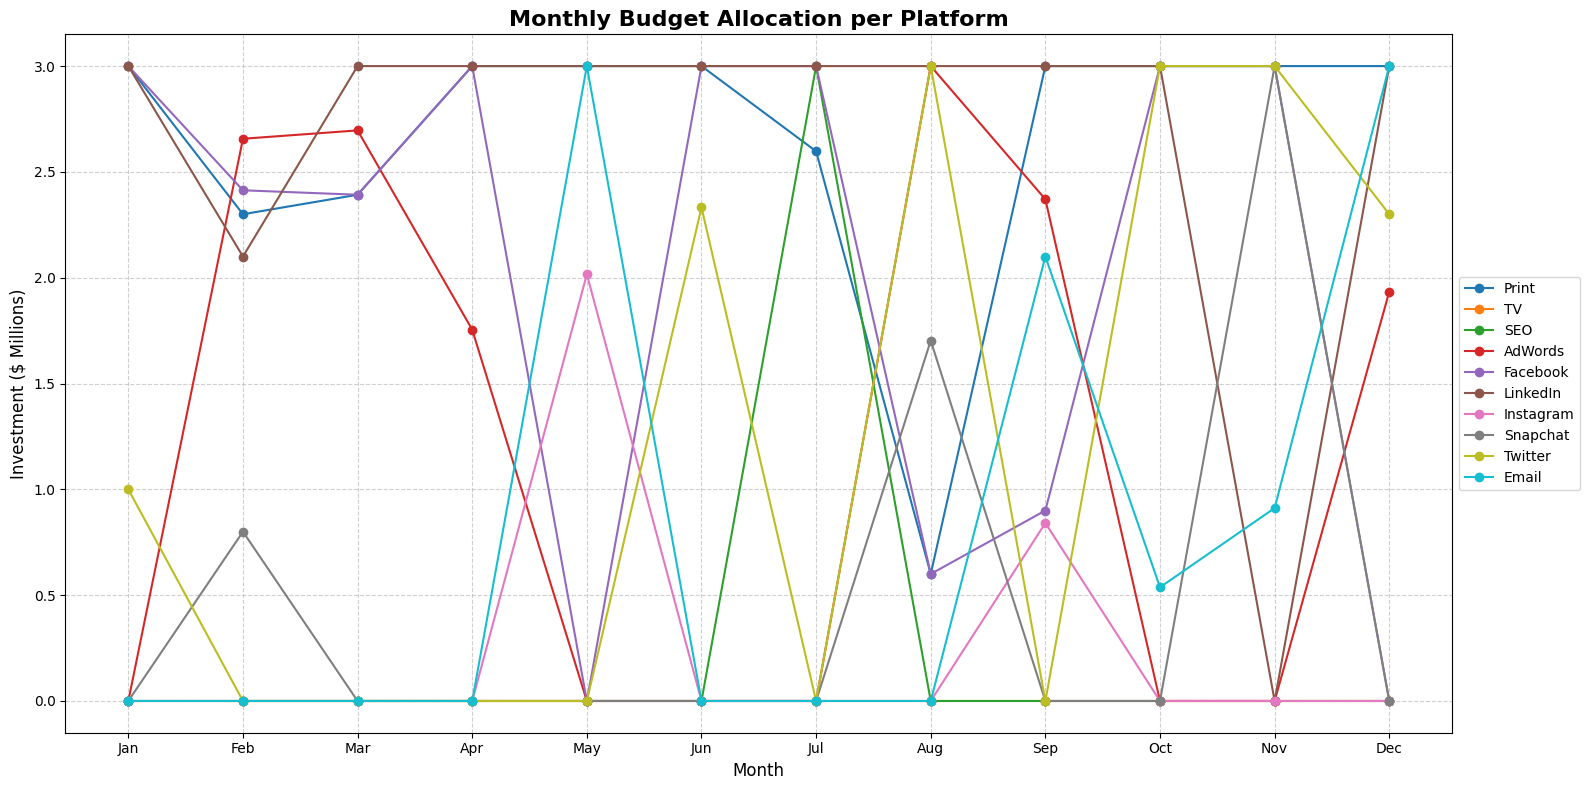

In [26]:
platforms_to_plot = [c for c in results_df.columns if c not in ["Month","Budget","ROI(%)","Return($M)"]]
months_order = list(roi_monthly["Month"].unique()) # Get the correct month order

# Set 'Month' as index to make plotting easier and respect calendar order
plot_df = results_df.set_index('Month').reindex(months_order)

plt.figure(figsize=(16, 8))
for p in platforms_to_plot:
    plt.plot(plot_df.index, plot_df[p], marker='o', linestyle='-', label=p)

plt.title('Monthly Budget Allocation per Platform', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Investment ($ Millions)', fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.yticks(np.arange(0, 3.5, 0.5))
plt.tight_layout()
plt.show()